In [8]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import os

import librosa as l
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Keras
import keras
import keras_metrics
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop

In [9]:
#%pip install keras_metrics

In [10]:
final_df = pd.read_csv('../Datasets/merged_df.csv')

# drop first column
final_df.drop('Unnamed: 0', axis='columns', inplace=True)

# train-test split dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_df_testing = final_df.copy()
final_df_testing = shuffle(final_df_testing)

X = final_df_testing.drop(columns=['Path', 'Emotions'], axis=1)
y = final_df_testing['Emotions']
print(X.shape, y.shape)

(23364, 173) (23364,)


In [11]:
# Handle imbalance classes with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

print('Original dataset shape', Counter(y))
print('\n')
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 2192, 3: 2192, 4: 2192, 2: 2192, 6: 2192, 5: 1920, 11: 1534, 10: 1534, 8: 1534, 14: 1534, 12: 1534, 13: 1246, 7: 992, 1: 192, 15: 192, 9: 192})


Resample dataset shape Counter({0: 2192, 11: 2192, 10: 2192, 3: 2192, 5: 2192, 1: 2192, 8: 2192, 4: 2192, 7: 2192, 2: 2192, 6: 2192, 14: 2192, 13: 2192, 12: 2192, 15: 2192, 9: 2192})


In [12]:
X_train

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MEL124,MEL125,MEL126,MEL127,TONZ0,TONZ1,TONZ2,TONZ3,TONZ4,TONZ5
31456,-279.123055,63.760904,1.625940,17.114450,9.503120,3.321982,-8.501130,-0.774408,-4.299198,-8.084149,...,3.928706e-04,3.647327e-04,3.571662e-04,3.911988e-04,0.018306,0.014543,-0.076503,-0.006564,-0.001193,-0.008806
3063,-432.575193,129.368471,14.792868,43.967532,-6.657468,8.753294,-14.892513,5.050620,-2.488246,3.223699,...,7.997952e-07,8.011242e-07,7.743340e-07,8.509561e-07,0.008090,0.021694,-0.063063,-0.038089,0.029000,0.000876
24585,-602.047086,17.077590,9.197620,3.721733,-1.565559,-4.385133,-7.882049,-5.339837,-3.356450,-3.177335,...,5.752760e-05,3.636439e-05,2.457540e-05,3.615490e-06,-0.016635,0.018818,-0.011808,0.012079,-0.009869,-0.005963
6531,-405.355930,84.337100,28.338491,37.896740,4.027435,7.227526,-5.615257,-17.847650,6.181924,-8.717045,...,3.523197e-03,2.794212e-03,1.663559e-03,1.053793e-04,-0.014367,0.060956,-0.213393,0.053001,-0.026599,0.042558
26280,-366.295494,34.348350,-0.024483,-2.435943,-20.655927,-4.387802,-1.612768,-12.897728,-12.341788,5.971213,...,2.862090e-03,2.637842e-03,2.149942e-03,2.397844e-04,-0.008419,-0.023956,-0.020645,0.044081,-0.005698,0.009209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,-453.329160,145.147160,12.177938,68.636610,-20.183788,30.991257,-23.718277,15.817014,-11.033003,4.793704,...,8.114301e-09,7.965489e-09,7.869681e-09,7.810058e-09,0.010157,0.015476,-0.047333,-0.062214,0.018298,0.006471
6265,-167.040350,38.408362,11.467246,17.375323,-3.852937,-14.781978,-8.458903,-4.084816,-8.432028,-3.148918,...,1.131528e-02,1.074235e-02,1.089415e-02,1.032721e-02,-0.002007,-0.027557,0.020920,-0.071943,-0.006125,0.019696
11284,-356.041884,119.874144,14.146783,41.384644,-18.864293,2.809063,-5.033281,1.902656,-15.956466,3.256168,...,4.684624e-06,4.565298e-06,4.842565e-06,5.002153e-06,-0.018206,-0.020570,-0.092024,-0.056901,0.026110,-0.005542
860,-285.048280,80.136536,9.950232,30.744112,-3.872049,7.284999,-4.162607,-0.706056,-15.087256,0.629732,...,3.813715e-09,3.733086e-09,3.680964e-09,3.648162e-09,-0.054863,-0.032680,-0.087250,0.050556,0.025336,-0.016530


## Using the same model used for the non-augmented and augmented data, we will now use it for the combined data

In [13]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, kernel_size=5, strides=1, # first convulational layer
                        padding="same", activation="relu",
                        input_shape=(X_smote.shape[1], 1))) 
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=5, strides=1,  # second convulational layer
                        padding="same", activation="relu"))
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten()) # flatten into a 1D array
model.add(layers.Dense(128, activation='relu')) # fully connected layer
model.add(layers.Dense(64, activation='relu')) # fully connected layer

model.add(layers.Dense(16, activation="softmax")) # output layer

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 173, 128)          768       
                                                                 
 conv1d_3 (Conv1D)           (None, 173, 64)           41024     
                                                                 
 flatten_1 (Flatten)         (None, 11072)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1417344   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
Total params: 1468432 (5.60 MB)
Trainable params: 1468

In [14]:
# Compile the model with appropriate Loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

#sparse_categorical_crossentropy --> when targets are integer & suitable for multiclasses
#categorical_crossentropy --> when targets are one-hot encoded vectors (binary) 

epochs = 41
 
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test)) 

Epoch 1/41
877/877 [==============================] - 36s 40ms/step - loss: 1.7563 - accuracy: 0.4313 - val_loss: 1.4452 - val_accuracy: 0.5384
Epoch 2/41
877/877 [==============================] - 35s 40ms/step - loss: 1.3089 - accuracy: 0.5642 - val_loss: 1.2610 - val_accuracy: 0.5857
Epoch 3/41
877/877 [==============================] - 35s 40ms/step - loss: 1.1783 - accuracy: 0.5979 - val_loss: 1.1706 - val_accuracy: 0.6024
Epoch 4/41
877/877 [==============================] - 35s 40ms/step - loss: 1.0949 - accuracy: 0.6203 - val_loss: 1.1098 - val_accuracy: 0.6130
Epoch 5/41
877/877 [==============================] - 35s 40ms/step - loss: 1.0397 - accuracy: 0.6353 - val_loss: 1.1042 - val_accuracy: 0.6145
Epoch 6/41
877/877 [==============================] - 35s 40ms/step - loss: 0.9915 - accuracy: 0.6508 - val_loss: 1.0198 - val_accuracy: 0.6449
Epoch 7/41
877/877 [==============================] - 35s 40ms/step - loss: 0.9473 - accuracy: 0.6619 - val_loss: 1.0130 - val_accuracy:

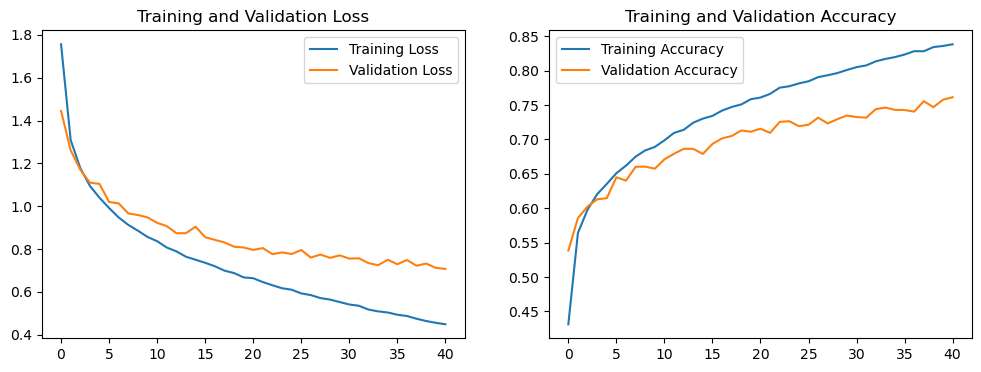

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions and calculate metrics
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test, predicted_classes))

220/220 [==============================] - 1s 6ms/step
Precision: 0.7623722901793929, Recall: 0.7613684960798289, F1-Score: 0.7593174953512787


              precision    recall  f1-score   support

           0       0.87      0.81      0.84       424
           1       0.95      0.99      0.97       432
           2       0.71      0.60      0.65       435
           3       0.79      0.68      0.73       445
           4       0.74      0.72      0.73       437
           5       0.73      0.80      0.76       461
           6       0.65      0.79      0.71       413
           7       0.94      1.00      0.97       422
           8       0.90      0.75      0.82       457
           9       0.92      1.00      0.95       424
          10       0.61      0.52      0.56       432
          11       0.60      0.66      0.63       442
          12       0.68      0.61      0.64       433
          13       0.60      0.71      0.65       482
          14       0.62      0.59      0.60 